***This notebook is dedicated to evaluated the kidney.csv dataset on the following classification models: logistic regression, k-nearest neighbor and random forest***

# Imports

In [1]:
# DATA MANIPULATION
import pandas as pd
import numpy as np

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config; set_config(display='diagram')



In [131]:
# sklearn preproc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
#from sklearn.feature_selection import SequentialFeatureSelector

from data import get_cleaned_data
from randomforest import RandomForest 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA



# Dataset loading

In [3]:
def get_data(url):
    df = pd.read_csv(url)
    return df

kidneys = get_data("../raw_data/kidney_disease.csv")
kidneys.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44.0,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38.0,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31.0,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,...,35.0,7300,4.6,no,no,no,good,no,no,ckd


# Dataset preprocess

## cleaning

In [4]:
def replacing_numerical_features(X):
    '''cleaning: strips \t at beginning of number and replaces ? with nan values'''
    X['pcv'] = X['pcv'].astype(str).str.lstrip("\t")
    X['pcv'] = X['pcv'].replace('?',np.nan).astype(float)
    X['wc'] = X['wc'].astype(str).str.lstrip("\t")
    X['wc'] = X['wc'].replace('?',np.nan).astype(float)
    X['rc'] = X['rc'].astype(str).str.lstrip("\t")
    X['rc'] = X['rc'].replace('?',np.nan).astype(float)
    return X

In [5]:
def preprocessing_1(df):
    # convert wc and rc columns to float
    df[['wc', 'rc']] = df[['wc','rc']].apply(pd.to_numeric, errors='coerce')
    df = replacing_numerical_features(df)
    return df


In [6]:
kidneys = preprocessing_1(kidneys)
kidneys.head(4)

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd


In [7]:
#def replacing_binary_features(X):
 #   '''encoding: replacing Yes --> 1 no --> 0'''
kidneys[['classification']] = kidneys[['classification']].replace(to_replace={'ckd':1,'notckd':0, 'ckd\t': 1})
kidneys[['htn','dm','cad','pe','ane']] = kidneys[['htn','dm','cad','pe','ane']].replace(to_replace={'yes':1,'no':0})
kidneys[['pe']] = kidneys[['pe']].replace(to_replace={'good':1})
kidneys[['htn']] = kidneys[['htn']].replace(to_replace={'4':4, '8':8, '?':np.nan, '5.2':5.2})
kidneys[['rbc','pc']] = kidneys[['rbc','pc']].replace(to_replace={'abnormal':1,'normal':0})
kidneys[['pcc','ba']] = kidneys[['pcc','ba']].replace(to_replace={'present':1,'notpresent':0})
kidneys[['appet']] = kidneys[['appet']].replace(to_replace={'good':2,'poor':1,'no':0})
    ## replacing t_values to 0 or 1, by assuming it s close to 0 or 1, respectively
kidneys[['cad']] = kidneys[['cad']].replace(to_replace='\tno',value=0)
kidneys[['dm']] = kidneys[['dm']].replace(to_replace={'\tno':0,'\tyes':1,' yes':1})
   # return X

In [8]:
def split_num_cat(df):
    # splitting numerical  and categorical features
    feat_num = list(df.nunique()[df.nunique() > 7].index)
    feat_cat = list(df.nunique()[df.nunique() <=7].index)
    feat_cat_bin = list(df[feat_cat].nunique()[df[feat_cat].nunique() ==2].index)
    feat_cat_ord = list(set(df.columns) - set(feat_num) - set(feat_cat_bin))

    #feat_num = df.select_dtypes(include=['float64', 'int64'])
    #feat_cat = df.drop(columns = feat_num.columns)
    # cleaning categorical features 
    
    #df_new = pd.concat([feat_cat, feat_num], axis = 1)
    return (feat_num, feat_cat_bin, feat_cat_ord)


In [9]:

feat_num = split_num_cat(kidneys)[0]
feat_cat_bin = split_num_cat(kidneys)[1]
feat_cat_ord = split_num_cat(kidneys)[2]

kidneys[feat_num]

,id,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc
0,0,48.0,80.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,7800.0,5.2
1,1,7.0,50.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,6000.0,NaN
2,2,62.0,80.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,7500.0,NaN
3,3,48.0,70.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,6700.0,3.9
4,4,51.0,80.0,106.0,26.0,1.4,NaN,NaN,11.6,35.0,7300.0,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...
395,395,55.0,80.0,140.0,49.0,0.5,150.0,4.9,15.7,47.0,6700.0,4.9
396,396,42.0,70.0,75.0,31.0,1.2,141.0,3.5,16.5,54.0,7800.0,6.2
397,397,12.0,80.0,100.0,26.0,0.6,137.0,4.4,15.8,49.0,6600.0,5.4
398,398,17.0,60.0,114.0,50.0,1.0,135.0,4.9,14.2,51.0,7200.0,5.9


In [10]:
def feat_target(a,b,c):
    df_new = pd.concat([pd.concat([a, b], axis =1),c], axis=1)
    return df_new

In [11]:
kidneys_new = feat_target(kidneys[feat_num], kidneys[feat_cat_bin],kidneys[feat_cat_ord])
kidneys_new.head(4)

,id,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,...,dm,cad,pe,ane,classification,su,htn,sg,appet,al
0,0,48.0,80.0,121.0,36.0,1.2,NaN,NaN,15.4,44.0,...,1.0,0.0,0.0,0.0,1,0.0,1.0,1.020,2.0,1.0
1,1,7.0,50.0,NaN,18.0,0.8,NaN,NaN,11.3,38.0,...,0.0,0.0,0.0,0.0,1,0.0,0.0,1.020,2.0,4.0
2,2,62.0,80.0,423.0,53.0,1.8,NaN,NaN,9.6,31.0,...,1.0,0.0,0.0,1.0,1,3.0,0.0,1.010,1.0,2.0
3,3,48.0,70.0,117.0,56.0,3.8,111.0,2.5,11.2,32.0,...,0.0,0.0,1.0,1.0,1,0.0,1.0,1.005,1.0,4.0


##  imputing and scaling (pipeline) 

In [12]:
def feat_target_split(df):
    # defining X and y
    X = df.drop(columns=['classification','id'])
    y = df['classification']
    X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size = 0.2)
    return (X,y, X_train, X_test, y_train, y_test)

In [13]:
X = feat_target_split(kidneys_new)[0]
y = feat_target_split(kidneys_new)[1]
X_train = feat_target_split(kidneys_new)[2]
X_test = feat_target_split(kidneys_new)[3]
y_train = feat_target_split(kidneys_new)[4]
y_test = feat_target_split(kidneys_new)[5]
X_train.head()

,age,bp,bgr,bu,sc,sod,pot,hemo,pcv,wc,...,ba,dm,cad,pe,ane,su,htn,sg,appet,al
138,73.0,NaN,95.0,51.0,1.6,142.0,3.5,NaN,NaN,NaN,...,0.0,NaN,0.0,1.0,0.0,0.0,0.0,1.01,0.0,1.0
215,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.01,2.0,3.0
202,78.0,60.0,114.0,74.0,2.9,135.0,5.9,8.0,24.0,NaN,...,0.0,1.0,0.0,0.0,1.0,NaN,0.0,NaN,2.0,NaN
302,29.0,70.0,127.0,44.0,1.2,145.0,5.0,14.8,48.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.02,2.0,0.0
140,69.0,70.0,256.0,40.0,1.2,142.0,5.6,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.01,2.0,0.0


In [14]:
def preprocessing_2(a,b,X):
    #remove y from the categorical features
    feat_cat_bin = b.drop(columns = 'classification')
    #remove id from the numerical features
    feat_num = a.drop(columns = 'id')
    return (list(feat_num.columns), list(feat_cat_bin.columns))

In [15]:

a = preprocessing_2(kidneys[feat_num], kidneys[feat_cat_bin], X)[0]
b = preprocessing_2(kidneys[feat_num], kidneys[feat_cat_bin], X)[1]
c = feat_cat_ord = split_num_cat(kidneys)[2]

In [16]:
def pipe(a,b,c):
    
    # imputing and scaling numerical features
    preproc_num = make_pipeline(SimpleImputer(strategy = "most_frequent"), MinMaxScaler())
    
    # imputing categorical features with unique values < 5
    preproc_cat = make_pipeline(SimpleImputer(strategy="most_frequent"))
    # scaling remaining (ordinal)
    preproc_cat_ord = make_pipeline(SimpleImputer(strategy="most_frequent"), MinMaxScaler())

    preproc_baseline = make_column_transformer((preproc_num, a),
    (preproc_cat, b),
    (preproc_cat_ord,c))

    return preproc_baseline

In [17]:
pipe = pipe(a,b,c)
pipe

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot',
                                  'hemo', 'pcv', 'wc', 'rc']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['rbc', 'pc', 'pcc', 'ba', 'dm', 'cad', 'pe',
                                  'ane']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['su', 'htn', 'sg', 'appet', 'al'])])

# Cleaned and scaled X_train and X_test

In [26]:
# final transformed X_train and X_test
SimpleImputer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)


X_train_transform = pipe.fit_transform(X_train)
pipe.get_feature_names_out()
X_train_final = pd.DataFrame(X_train_transform, columns=pipe.get_feature_names_out())

X_test_transform = pipe.fit_transform(X_test)
pipe.get_feature_names_out()
X_test_final = pd.DataFrame(X_test_transform, columns=pipe.get_feature_names_out())

In [27]:
X_test_final.head()

,pipeline-1__age,pipeline-1__bp,pipeline-1__bgr,pipeline-1__bu,pipeline-1__sc,pipeline-1__sod,pipeline-1__pot,pipeline-1__hemo,pipeline-1__pcv,pipeline-1__wc,...,pipeline-2__ba,pipeline-2__dm,pipeline-2__cad,pipeline-2__pe,pipeline-2__ane,pipeline-3__su,pipeline-3__htn,pipeline-3__sg,pipeline-3__appet,pipeline-3__al
0,0.543210,0.75,0.081690,0.211726,0.021192,0.896907,0.018059,0.417391,0.371429,0.281609,...,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.000000,0.0,0.4
1,0.716049,0.00,0.614085,0.068404,0.015894,0.862543,0.006772,0.139130,0.171429,0.632184,...,0.0,0.0,0.0,0.0,1.0,0.25,1.0,0.000000,0.5,0.6
2,0.864198,0.75,0.670423,0.068404,0.026490,0.869416,0.036117,0.756522,0.714286,0.143678,...,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.666667,0.5,0.0
3,0.185185,0.00,0.123944,0.114007,0.006623,0.896907,0.049661,0.686957,0.914286,0.172414,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.000000,1.0,0.0
4,0.888889,0.00,0.050704,0.114007,0.001325,0.979381,0.022573,0.947826,0.971429,0.103448,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.666667,1.0,0.0


# Add a logistic regression estimator and crossvalidate

## checking if matrix is full rank

In [28]:
np.linalg.matrix_rank(X_train_final)

24

In [29]:
# Instantiating the model
logreg = LogisticRegression(max_iter = 200)

# adding an estimator to the pipeline
baseline_pipe = make_pipeline(pipe, logreg)   # adding an estimator to the pipeline
baseline_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'bp', 'bgr', 'bu',
                                                   'sc', 'sod', 'pot', 'hemo',
                                                   'pcv', 'wc', 'rc']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['rbc', 'pc', 'pcc', 'ba',
                                                   'dm', 'cad', 'pe', 'ane']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['su', 'htn', 'sg', 'appet',
                                                   'al'])])),
                ('logisticregression', LogisticRegression(max_iter=200))])

In [30]:
# crossvalidating the logistic regression
baseline_score = cross_val_score(baseline_pipe, X, y, cv = 5, scoring='recall').mean() 
baseline_score

0.9193262411347518

# feature selection

## correlation between features

<AxesSubplot:>

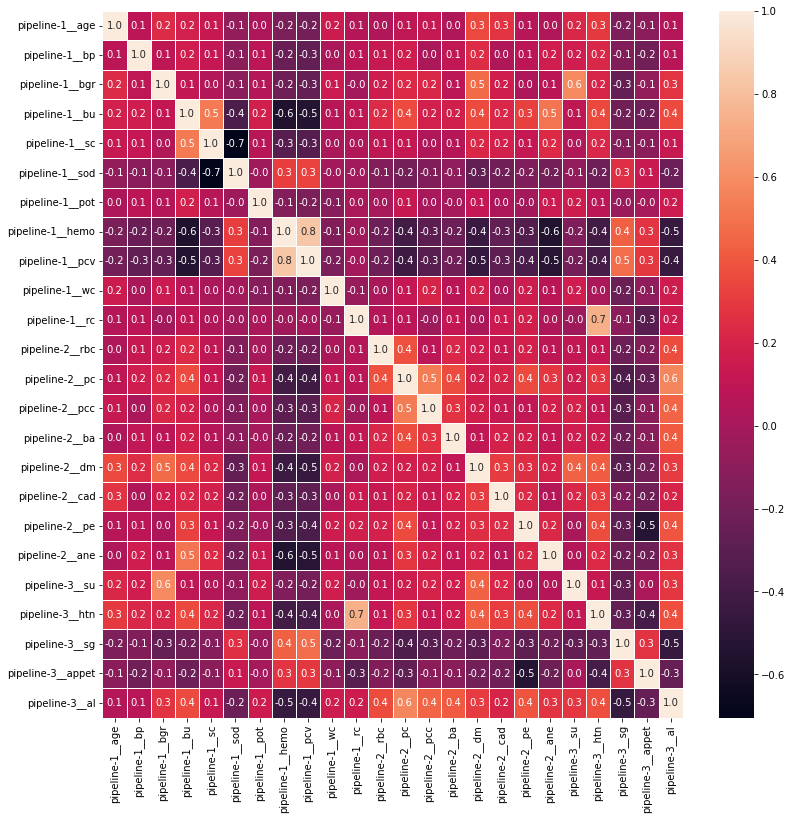

In [160]:
f,ax = plt.subplots(figsize=(13, 13))
sns.heatmap(X_train_final.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

there a strong correlation between 'pcv' and 'hemo' as well between 'rc' and 'htn'. 

## feature selection with correlation and randomforest

### confusion matrix where no feature is removed

(<AxesSubplot:>, 'Accuracy is 0.5375')

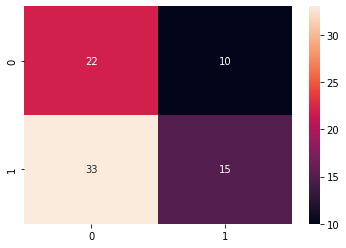

In [83]:

#random forest classifier 
def confusion_score(classifier, X_train,y_train, y_test,X_test):
    #clf_rf = RandomForestClassifier(random_state=43)      
    clr_rf = classifier.fit(X_train,y_train)

    ac = accuracy_score(y_test,classifier.predict(X_test))
    cm = confusion_matrix(y_test,clf_rf.predict(X_test))
    return(sns.heatmap(cm,annot=True,fmt="d"), f'Accuracy is {ac}')
confusion_score(RandomForestClassifier(), X_train_final,y_train,y_test,X_test_final)

### let's remove 'hemo' and 'htn' and redo the above  (not working :-( )

In [92]:
feat_to_drop = ['pipeline-1__hemo', 'pipeline-3__htn']
X_1_train = X_train_final.drop(feat_to_drop,axis = 1 )        
X_1_test = X_test_final.drop(feat_to_drop,axis = 1 )        # do not modify x, we will use it later 

#confusion_score(RandomForestClassifier(), X_1_train,y_train,y_test, X_1_test)
#X_1_train.shape

###  feature selection using SelectKBest

,features,scores
0,age,0.086844
1,bp,0.001200
2,bgr,0.376204
3,bu,0.794427
4,sc,0.001097


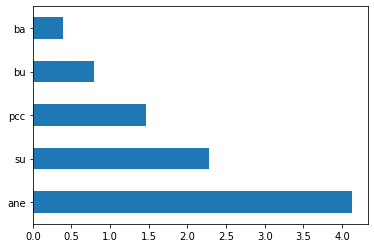

In [130]:
#apply SelectKBest class to extract top 5 best features
best_RF = SelectKBest(score_func=chi2, k=5).fit(X_train_final,y_train)
dfscores = pd.DataFrame(best_RF.scores_)
dfcolumns = pd.DataFrame(X_train.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['features','scores']   #naming the dataframe columns

feat_importances_SB = pd.Series(best_RF.scores_, index=X.columns)
feat_importances_SB.nlargest(5).plot(kind='barh')
#featureScores.head(5)

### confusion matrix after selection 

Accuracy is:  0.5125


<AxesSubplot:>

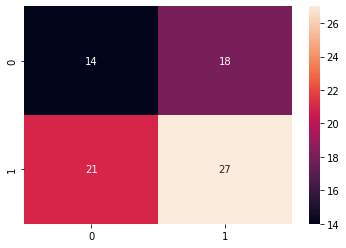

In [94]:
X_train_2 = best_RF.transform(X_train_final)
X_test_2 = best_RF.transform(X_test_final)

#random forest classifier 

clf_rf_2 = RandomForestClassifier()      
clr_rf_2 = clf_rf_2.fit(X_train_2,y_train)
ac_2 = accuracy_score(y_test,clf_rf_2.predict(X_test_2))
print('Accuracy is: ',ac_2)
cm_2 = confusion_matrix(y_test,clf_rf_2.predict(X_test_2))
sns.heatmap(cm_2,annot=True,fmt="d")

the score does not improve! let's try another selection approach

### selection using recursive feature elimination

Accuracy is:  0.45
Chosen best 5 feature by rfe: Index(['age', 'bgr', 'bu', 'hemo', 'wc'], dtype='object')


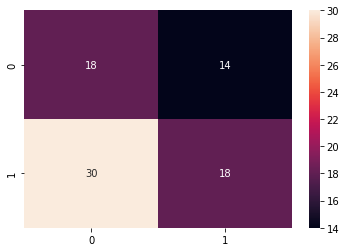

In [99]:
# Create the RFE object and rank each pixel
clf_rf_3 = RandomForestClassifier()      
rfe = RFE(estimator=clf_rf_3, n_features_to_select=5, step=1)
rfe = rfe.fit(X_train_final, y_train)
X_train_3 = rfe.transform(X_train_final)
X_test_3 = rfe.transform(X_test_final)

#random forest classifier 

clr_rf_3 = clf_rf_3.fit(X_train_3,y_train)
ac_3 = accuracy_score(y_test,clf_rf_3.predict(X_test_3))
print('Accuracy is: ',ac_3)
cm_3 = confusion_matrix(y_test,clf_rf_3.predict(X_test_3))
sns.heatmap(cm_3,annot=True,fmt="d")

print('Chosen best 5 feature by rfe:',X_train.columns[rfe.support_])

three features in common with selectKBest

## Recursive feature elimination with cross validation and random forest classification (to get the optimal number of features to be selected)


In [110]:

# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier()
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='recall')   #5-fold cross-validation
rfecv = rfecv.fit(X_train_final, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 20
Best features : Index(['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc',
       'pc', 'dm', 'pe', 'ane', 'su', 'htn', 'sg', 'appet', 'al'],
      dtype='object')


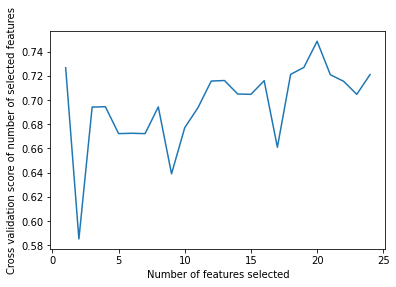

In [123]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, rfecv.cv_results_['mean_test_score'].shape[0] +1) , rfecv.cv_results_['mean_test_score'])
plt.show()

## Tree based feature selection and random forest classification

Feature ranking:
1. feature 9 (0.105357)
2. feature 3 (0.099649)
3. feature 0 (0.092307)
4. feature 2 (0.082573)
5. feature 7 (0.079066)
6. feature 4 (0.072680)
7. feature 6 (0.072556)
8. feature 8 (0.071594)
9. feature 10 (0.064373)
10. feature 5 (0.061840)
11. feature 1 (0.037297)
12. feature 21 (0.027687)
13. feature 23 (0.023891)
14. feature 19 (0.018437)
15. feature 22 (0.015071)
16. feature 15 (0.012391)
17. feature 18 (0.010574)
18. feature 17 (0.009911)
19. feature 11 (0.009052)
20. feature 20 (0.009009)
21. feature 12 (0.008340)
22. feature 13 (0.006263)
23. feature 16 (0.005429)
24. feature 14 (0.004653)


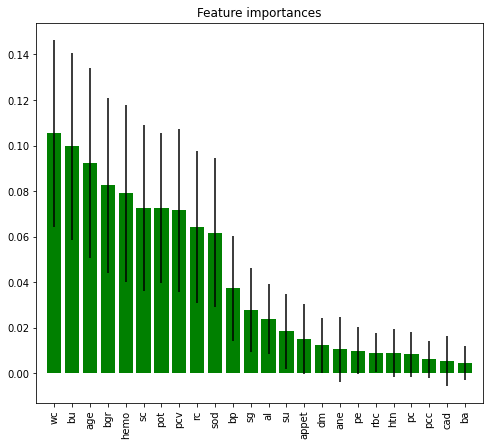

In [137]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(X_train_final,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(8, 7))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Feature Extraction with PCA

Text(0, 0.5, 'explained_variance_ratio_')

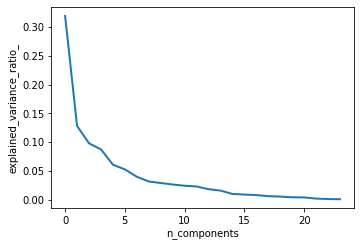

In [134]:
pca = PCA()
pca.fit(X_train_final)

plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

## RFE with logistic regression

In [161]:
### with all the 24 features

lr = LogisticRegression()
lr.fit(X_train_final, y_train)
y_guess = lr.predict(X_train_final)
y_score = lr.predict(X_test_final)
print("Accuracy no feature selection:",accuracy_score(y_test, y_score))

Accuracy no feature selection: 0.525


In [155]:
# with the 5 top features
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select=10).fit(X_train_final, y_train)
y_guess = rfe.predict(X_train_final)
y_score = rfe.predict(X_test_final)
#print("Num Features: %d" % rfe.n_features_)
#print("Selected Features: %s" % rfe.support_)
print("Accuracy with feature selection:",accuracy_score(y_test, y_score))


Accuracy with feature selection: 0.525


In [158]:
## chosen features
rfe_support = rfe.get_support()

rfe_feature = X.loc[:,rfe_support].columns.tolist()
rfe_feature

['age', 'bgr', 'bu', 'sc', 'sod', 'pcc', 'ba', 'pe', 'ane', 'su']